# Sentiment analysis for movie reviews
Given a review about a movie written by some user, decide whether it's positive, negative or neutral.

![](imgs/move_review_exp.png)

In [1]:
# imports:

%matplotlib inline
import os
import sys
import time
import torch
import matplotlib.pyplot as plt
from sklearn import metrics
import warnings
warnings.simplefilter("ignore")

import torch
import torch.nn as nn
import torchtext
import torchtext.data as data
import torchtext.datasets as datasets
import torch.nn.functional as f
import torch.optim as optim

plt.rcParams['font.size'] = 20
data_dir = os.getcwd()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Dataset
We'll be using the Stanford Sentiment Treebank (SST) dataset, which contains about 10,000 labeled movie reviews.

    ("This movie was actually neither that funny, nor super witty.", "neutral")

### Loading and tokenizing text samples
The `torchtext.data.Field` class takes care of splitting text into unique tokens (words), and converting them into a numerical representation.

In [3]:
import torchtext.data 

review_parser = torchtext.data.Field(
    sequential=True, use_vocab=True, lower=True,
    init_token='<sos>', eos_token='<eos>', dtype=torch.long,
    tokenize='spacy', tokenizer_language='en_core_web_sm'
)

label_parser = torchtext.data.Field(
    is_target=True, sequential=False, unk_token=None, use_vocab=True
)

In [4]:
# example of review/label parsers:
review, label = "This movie is great! I really enjoyed it.", "positive"
review_parser.build_vocab([review])
label_parser.build_vocab([label])
processed_review, processed_label = review_parser.process([review]), label_parser.process([label])
numerical_review = processed_review.view(-1).numpy()
numerical_label = processed_label.view(-1).numpy()
print("Processed review (tokens):\n", processed_review.view(-1).numpy())
print("Processed label:", processed_label.view(-1).numpy())


Processed review (tokens):
 [ 2 17 20  6 11  4 22  9 24  6  5  4  6 11  4 19 10  5  7 12 14  4 16  4
 10  5  7  8  8 13  4  5 23 21  9 13  5 18  4  6 12 15  3]
Processed label: [0]


In [5]:
import torchtext.datasets

ds_train, ds_valid, ds_test = torchtext.datasets.SST.splits(
    review_parser, label_parser, root=data_dir
)

n_train = len(ds_train)
print(f'Number of training samples: {n_train}')
print(f'Number of test     samples: {len(ds_test)}')

Number of training samples: 8544
Number of test     samples: 2210


In [6]:
# examples from training set:
for i in ([111, 4321, 7777, 0]):
    example = ds_train[i]
    label = example.label
    review = str.join(" ", example.text)
    print(f'sample#{i:04d} [{label:8s}]:\n > {review}\n')

sample#0111 [positive]:
 > the film aims to be funny , uplifting and moving , sometimes all at once .

sample#4321 [neutral ]:
 > the most anti - human big studio picture since 3000 miles to graceland .

sample#7777 [negative]:
 > an ugly , revolting movie .

sample#0000 [positive]:
 > the rock is destined to be the 21st century 's new ` ` conan '' and that he 's going to make a splash even greater than arnold schwarzenegger , jean - claud van damme or steven segal .



### Building a vocabulary
the `Field` object can build a vocab, which is a bi-directional mapping between a unique index and a token.

In [7]:
review_parser.build_vocab(ds_train)
label_parser.build_vocab(ds_train)

print(f"Number of tokens in training samples: {len(review_parser.vocab)}")
print(f'first 20 tokens:\n', review_parser.vocab.itos[:20], end='\n')
# Show that some words exist in the vocab
for w in ['the', 'actor', 'schwarzenegger', 'spielberg']:
    print(f'word={w:15s} index={review_parser.vocab.stoi[w]}')
print()
print(f"Number of tokens in training labels: {len(label_parser.vocab)}")
print(f'label tokens:\n', label_parser.vocab.itos, end='\n')
print(f'labels vocab:\n', dict(label_parser.vocab.stoi))
# plt.figure(figsize=(5, 3))  
# plt.hist(hist)
# plt.show()

Number of tokens in training samples: 15451
first 20 tokens:
 ['<unk>', '<pad>', '<sos>', '<eos>', '.', 'the', ',', 'a', 'and', 'of', 'to', '-', 'is', "'s", 'it', 'that', 'in', 'as', 'but', 'film']
word=the             index=5
word=actor           index=493
word=schwarzenegger  index=3406
word=spielberg       index=718

Number of tokens in training labels: 3
label tokens:
 ['positive', 'negative', 'neutral']
labels vocab:
 {'positive': 0, 'negative': 1, 'neutral': 2}


### Dataloaders (iterators)
the torchtext package uses iterators instead of dataloaders.

each text sample has a different length.

In [8]:
BATCH_SIZE = 4

# BucketIterator creates batches with samples of similar length
# to minimize the number of <pad> tokens in the batch.
dl_train, dl_valid, dl_test = torchtext.data.BucketIterator.splits(
    (ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE,
    shuffle=True, device=device)



In [9]:
# example of a single batch:
batch = next(iter(dl_train))

X, y = batch.text, batch.label # X is of shape (sentence_length, batch_size)
print('X = \n', X, X.shape, end='\n\n')
print('y = \n', y, y.shape)

X = 
 tensor([[    2,     2,     2,     2],
        [    5,     5,    18,     5],
        [   19,    19,     5,    65],
        [  301,    31,    19,  3313],
        [   24,  1064,   225,     6],
        [  532,   450,    12,   168],
        [   56,   677,   215,    11],
        [   11,    11,   196,  1192],
        [   50,  9554, 14935,     8],
        [  334,   115,     4,    64],
        [    4,   112,     3,   832],
        [    3,    56,     1,   865],
        [    1,    89,     1,    24],
        [    1,    26,     1,  1506],
        [    1,    46,     1,    21],
        [    1,   322,     1,     7],
        [    1,    10,     1,    22],
        [    1,  3469,     1,    17],
        [    1,   109,     1,    26],
        [    1,     3,     1,    71],
        [    1,     1,     1,   601],
        [    1,     1,     1,     4],
        [    1,     1,     1,     3]]) torch.Size([23, 4])

y = 
 tensor([0, 0, 1, 1]) torch.Size([4])


## Model
we'll implement 5 models: rnn, lstm, gru, attention, and transformer, and compare them.

The model will:

* Take an input batch of tokenized sentences.
* Compute a dense word-embedding of each token.
* Process the sentence sequentially through the RNN layer.
* Produce a (B, 3) tensor, which we'll interpret as class probabilities for each sentence in the batch.


### word embedding
Embeddings encode tokens as tensors in a way that maintains some semantic meaning for our task.

In [85]:
# example embedding layer:
embedding_layer = nn.Embedding(num_embeddings=5, embedding_dim=8)
token_idx = torch.randint(low=0, high=5, size=(3,2))
print(token_idx, token_idx.shape)
print(embedding_layer(token_idx), embedding_layer(token_idx).shape)

tensor([[1, 4],
        [0, 0],
        [4, 0]]) torch.Size([3, 2])
tensor([[[-1.3718,  1.4921,  0.9213,  0.1127, -0.0740, -0.1174, -0.2028,
           0.6659],
         [-1.0653, -0.0954,  0.1377, -1.2526, -0.2874,  0.8610, -0.6706,
          -0.1577]],

        [[ 1.3391,  0.6923, -0.8190, -0.0954,  0.1856, -0.3917, -1.0556,
           3.0313],
         [ 1.3391,  0.6923, -0.8190, -0.0954,  0.1856, -0.3917, -1.0556,
           3.0313]],

        [[-1.0653, -0.0954,  0.1377, -1.2526, -0.2874,  0.8610, -0.6706,
          -0.1577],
         [ 1.3391,  0.6923, -0.8190, -0.0954,  0.1856, -0.3917, -1.0556,
           3.0313]]], grad_fn=<EmbeddingBackward0>) torch.Size([3, 2, 8])


### RNN

![](imgs/rnn_cell.png)

the formulas for each part are:

![](imgs/rnn_formulas.png)

In [10]:
class RNNLayer(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim, phi_h=torch.tanh, phi_y=torch.sigmoid):
        super().__init__()
        self.phi_h = phi_h
        self.phi_y = phi_y
        self.fc_xh = nn.Linear(in_dim, h_dim, bias=False)
        self.fc_hh = nn.Linear(h_dim, h_dim, bias=True)
        self.fc_hy = nn.Linear(h_dim, out_dim, bias=True)

    def forward(self, xt, h_prev=None):
        if h_prev is None:
            h_prev = torch.zeros(xt.shape[0], self.fc_hh.in_features)
        ht = self.phi_h(self.fc_xh(xt) + self.fc_hh(h_prev))
        yt = self.fc_hy(ht)
        if self.phi_y is not None:
            yt = self.phi_y(yt)
        return yt, ht


In [38]:
# class SentimentRNN(nn.Module):
#     def __init__(self, vocab_dim, embedding_dim, h_dim, out_dim):
#         super().__init__()

#         # token index to dense tensor
#         self.embedding = nn.Embedding(num_embeddings=vocab_dim, embedding_dim=embedding_dim) 

#         # no phi_y so it outputs a class score
#         self.rnn = RNNLayer(in_dim=embedding_dim, h_dim=h_dim, out_dim=out_dim, phi_y=None)

#         # class scores to log-probs
#         self.log_softmax = nn.LogSoftmax(dim=1)

#     def forward(self, X):
#         # X shape is (Seq_len, Batch_size)
#         embedded = self.embedding(X) # embedded shape (S, B, E)

#         # loop over tokens in the input:
#         ht = None
#         for xt in embedded: # each xt is (B,E)
#             yt, ht = self.rnn(xt, ht) # yt is (B, out_dim)
#         yt_log_prob = self.log_softmax(yt)

#         return yt_log_prob

class SentimentRNN(nn.Module):
    def __init__(self, vocab_dim, embedding_dim, h_dim, out_dim):
        super().__init__()
        
        # nn.Embedding converts from token index to dense tensor
        self.embedding = nn.Embedding(vocab_dim, embedding_dim)
        
        # Our own Vanilla RNN layer, without phi_y so it outputs a class score
        self.rnn = RNNLayer(in_dim=embedding_dim, h_dim=h_dim, out_dim=out_dim, phi_y=None)
        
        # To convert class scores to log-probability we'll apply log-softmax
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, X):
        # X shape: (S, B) Note batch dim is not first!
        
        embedded = self.embedding(X) # embedded shape: (S, B, E)
        
        # Loop over (batch of) tokens in the sentence(s)
        ht = None
        for xt in embedded:           # xt is (B, E)
            yt, ht = self.rnn(xt, ht) # yt is (B, D_out)
        
        # Class scores to log-probability
        yt_log_proba = self.log_softmax(yt)
        
        return yt_log_proba


In [12]:
# rnn model init:
INPUT_DIM = len(review_parser.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 3

model = SentimentRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model

SentimentRNN(
  (embedding): Embedding(15451, 100)
  (rnn): RNNLayer(
    (fc_xh): Linear(in_features=100, out_features=128, bias=False)
    (fc_hh): Linear(in_features=128, out_features=128, bias=True)
    (fc_hy): Linear(in_features=128, out_features=3, bias=True)
  )
  (log_softmax): LogSoftmax(dim=1)
)

In [13]:
# forward pass test:
batch = next(iter(dl_train))
X, y = batch.text, batch.label
print(f'model(X) = \n', model(X), model(X).shape) # each row is prob of a sentence 
print(f'true labels = ', y)
y_pred = torch.argmax(model(X), dim=1)
print(f'predicted labels = ', y_pred)

model(X) = 
 tensor([[-1.2529, -0.9057, -1.1709],
        [-1.2529, -0.9057, -1.1709],
        [-1.0281, -1.2577, -1.0272],
        [-1.2529, -0.9057, -1.1709]], grad_fn=<LogSoftmaxBackward0>) torch.Size([4, 3])
true labels =  tensor([1, 0, 0, 1])
predicted labels =  tensor([1, 1, 2, 1])


In [14]:
# model size:
print(f'The RNN model has {count_parameters(model):,} trainable weights.')

The RNN model has 1,574,799 trainable weights.


Training

In [39]:
def train(model, optimizer, loss_fn, dataloader, max_epochs=100, max_batches=200, print_results = False):
    loss_values = []
    accuracy_values = []
    for epoch_idx in range(max_epochs):
        total_loss, num_correct = 0, 0
        start_time = time.time()

        for batch_idx, batch in enumerate(dataloader):
            X, y = batch.text, batch.label

            # Forward pass
            y_pred_log_proba = model(X)

            # Backward pass
            optimizer.zero_grad()
            loss = loss_fn(y_pred_log_proba, y)
            loss.backward()

            # Weight updates
            optimizer.step()

            # Calculate accuracy
            total_loss += loss.item()
            y_pred = torch.argmax(y_pred_log_proba, dim=1)
            num_correct += torch.sum(y_pred == y).float().item()

            if batch_idx == max_batches-1:
                break
            
        loss_values.append(total_loss / max_batches)
        accuracy_values.append(num_correct /(max_batches*BATCH_SIZE))
        if print_results:
            print(f"Epoch #{epoch_idx}, loss={total_loss /(max_batches):.3f}, accuracy={num_correct /(max_batches*BATCH_SIZE):.3f}, elapsed={time.time()-start_time:.1f} sec")

    return loss_values, accuracy_values


def display_train_results(loss_values, accuracy_values):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(loss_values, label='Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].set_title('Training Loss')
    axes[0].grid(True)
    axes[1].plot(accuracy_values, label='Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].set_title('Training Accuracy')
    axes[1].grid(True)
    plt.tight_layout()
    plt.show()



In [51]:
def train(model, optimizer, loss_fn, dataloader, max_epochs=100, max_batches=200):
    for epoch_idx in range(max_epochs):
        total_loss, num_correct = 0, 0
        start_time = time.time()

        for batch_idx, batch in enumerate(dataloader):
            X, y = batch.text, batch.label

            # Forward pass
            y_pred_log_proba = model(X)

            # Backward pass
            optimizer.zero_grad()
            loss = loss_fn(y_pred_log_proba, y)
            loss.backward()

            # Weight updates
            optimizer.step()

            # Calculate accuracy
            total_loss += loss.item()
            y_pred = torch.argmax(y_pred_log_proba, dim=1)
            num_correct += torch.sum(y_pred == y).float().item()

            if batch_idx == max_batches-1:
                break
                
        print(f"Epoch #{epoch_idx}, loss={total_loss /(max_batches):.3f}, accuracy={num_correct /(max_batches*BATCH_SIZE):.3f}, elapsed={time.time()-start_time:.1f} sec")

In [57]:
# rnn_model = SentimentRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
# optimizer = optim.Adam(rnn_model.parameters(), lr=1e-3)

# # logSoftmax + NLL = ce of the class scores
# loss_fn = nn.NLLLoss()

# loss_values, accuracy_values = train(rnn_model, optimizer, loss_fn, dl_train, max_epochs=200)


rnn_model = SentimentRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

optimizer = optim.Adam(rnn_model.parameters(), lr=1e-3)

# Recall: LogSoftmax + NLL is equiv to CrossEntropy on the class scores
loss_fn = nn.NLLLoss()

train(rnn_model, optimizer, loss_fn, dl_train, max_epochs=300) 


Epoch #0, loss=1.093, accuracy=0.394, elapsed=2.6 sec
Epoch #1, loss=1.090, accuracy=0.372, elapsed=2.6 sec
Epoch #2, loss=1.076, accuracy=0.414, elapsed=2.6 sec
Epoch #3, loss=1.082, accuracy=0.350, elapsed=2.5 sec
Epoch #4, loss=1.074, accuracy=0.400, elapsed=2.5 sec
Epoch #5, loss=1.062, accuracy=0.411, elapsed=2.5 sec
Epoch #6, loss=1.042, accuracy=0.439, elapsed=2.5 sec
Epoch #7, loss=1.063, accuracy=0.407, elapsed=2.6 sec
Epoch #8, loss=1.047, accuracy=0.425, elapsed=2.9 sec
Epoch #9, loss=1.066, accuracy=0.396, elapsed=2.6 sec
Epoch #10, loss=1.051, accuracy=0.426, elapsed=2.9 sec
Epoch #11, loss=1.110, accuracy=0.393, elapsed=2.6 sec
Epoch #12, loss=1.080, accuracy=0.395, elapsed=2.6 sec
Epoch #13, loss=1.080, accuracy=0.390, elapsed=2.6 sec
Epoch #14, loss=1.058, accuracy=0.443, elapsed=2.6 sec
Epoch #15, loss=1.073, accuracy=0.422, elapsed=2.7 sec
Epoch #16, loss=1.059, accuracy=0.427, elapsed=2.6 sec
Epoch #17, loss=1.074, accuracy=0.399, elapsed=2.7 sec
Epoch #18, loss=1.08

after 200 epochs (10 min) of training:


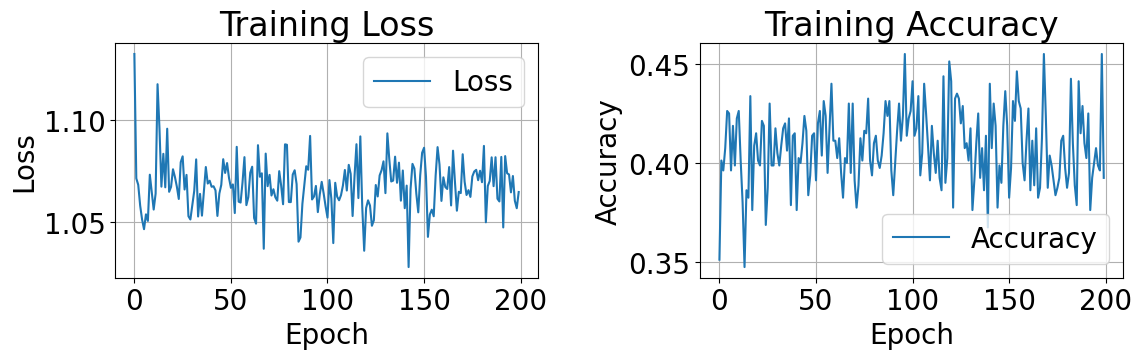

In [41]:
print("after 200 epochs (10 min) of training:")
display_train_results(loss_values, accuracy_values)

model evaluation

In [46]:
def print_stats(model, dataloader):
    model.eval()
    trues = []
    preds = []
    with torch.no_grad():
        for data in dataloader:
            X, y = data.text.to(device), data.label.to(device)
            trues += list(y.cpu())
            y_pred_log_prob = model(X)
            predicted = torch.argmax(y_pred_log_prob, dim=1)
            preds += list(predicted.cpu())
    print(metrics.classification_report(trues, preds, digits=3))


In [59]:
print_stats(rnn_model, dl_valid)

              precision    recall  f1-score   support

           0      0.404     0.941     0.565       444
           1      0.303     0.047     0.081       428
           2      0.000     0.000     0.000       229

    accuracy                          0.398      1101
   macro avg      0.236     0.329     0.215      1101
weighted avg      0.281     0.398     0.259      1101



In [58]:
print_stats(rnn_model, dl_train)

              precision    recall  f1-score   support

           0      0.423     0.983     0.591      3610
           1      0.433     0.018     0.035      3310
           2      0.000     0.000     0.000      1624

    accuracy                          0.423      8544
   macro avg      0.285     0.334     0.209      8544
weighted avg      0.346     0.423     0.263      8544

